# Training Autonomous Vehicles using Augmented Random Search (ARS) in Carla

## Outline
[Project Abstract](#abstract)<br>
The abstract of the project, summarizing the goals, research, methodology, and conclusion.

[The Math Behind ARS](#ars_math)<br>
This section explains the mechanics of the ARS learning process.

[Testing Car Environment with ARS](#testing_environment)<br>
This section involves testing a modified version of Sentdex's Carla 'CarEnv' environment in the [framework for ARS learning provided by Colin Skow](https://github.com/colinskow/move37/tree/master/ars), which has also been modified to make use of the environment.<br>

[Parallel Training using Ray](notebook2_train_agent.ipynb)<br>
This notebook makes use of a version of the [ARS framework made available by the authors of the 2018 ARS paper](https://github.com/modestyachts/ARS) that has been modified to make use of the modified Sentdex 'CarEnv' environment in a parallel fashion using a Ray cluster. This allows multiple workers to explore deltas simultaneously and pool the results of their rollouts at each update step, leading to faster training of the agent.

[Analysis of Results and Conclusions](notebook3_results_analysis.ipynb)<br>
This notebook reviews and analyzes the results obtained from the first round of training, and provides the conclusions of this study.

## Abstract
[Carla](https://carla.org/) is an open source driving simulator with a Python API used for autonomous driving research. Built on Unreal Engine 4, it employs high-end graphics to provide a suitable representation of the real world conducive for reinforcement learning with camera data. This research sought to test the ability of the [Augmented Random Searching (ARS) algorithm](https://arxiv.org/pdf/1803.07055.pdf) to train a self-driving car policy on the data gathered from a single front-facing camera per car. ARS is an exciting new algorithm for reinforcement learning (RL) proposed in 2018 by Mania, Guy, and Recht, which has been shown to achieve competitive results on benchmark MuJoCo continuous control locomotion tasks compared to more complex model-free methods, while offering at least 15x more computational efficiency. This significant reduction in computational resource requirements makes it an attractive algorithm for small-scale autonomous vehicle research, and so it was chosen for this study. 

Code for usable car environment for this task was derived from a [Sentdex tutorial on using Carla for Deep Q-Learning](https://pythonprogramming.net/introduction-self-driving-autonomous-cars-carla-python/) and modified to fit the context of ARS learning. The modified environment was then tested by splicing it into [ARS code provided by Colin Skow](https://github.com/colinskow/move37/tree/master/ars) as a part of his course on RL. Once the environment was functional with ARS learning, the ability to train in parallel was achieved by modifying the [code provided by the authors of the ARS study](https://github.com/modestyachts/ARS) to make use of this car environment. This allowed testing of the efficacy of this efficient learning algorithm on training autonomous vehicles using camera data from Carla. To convert the raw RGB camera data into feature space, it was first passed through the pretrained VGG19 convolutional neural network using imagenet weights, without the top layer.

A reward system was devised which penalized collisions, extreme steering control values, and sitting stationary, while rewarding traveling at speed especially when moving in straight lines. Much experimentation was done in creating this reward system, but it is likely that more adjustments need to be made in the future to facilitate the learning process.

Even despite the simplicity of the ARS algorithm, the personal computer used for training was only able to handle training with 4 workers in parallel due to the high computational demands of the Carla simulator, and this led to the process of learning being slow. Testing a range of hyperparameter values for learning rate, number of deltas tested/used, and delta std would require multiple deployments of a multi-day training process, and it is understandable that optimal balance of these parameter values for this task has not been found by this study, which only represents the first attempt at training using this framework. Instructions for running the parallelized training process can be found in the '[notebook2_train_agent](notebook2_train_agent.ipynb)' notebook.

An in-depth review and analysis of the results of the training can be found in the '[notebook3_results_analysis](notebook3_results_analysis.ipynb)' notebook in this repository, along with the conclusions of this study. In summary, the first 5-day round of training did not lead to a noticably improving policy for the agent by the end of the 1250 iteration training period. It is possible that the learning rate and delta std was set too high for this task, and further testing using different values is needed. It may also be necessary to control the variability of the circumstances that each delta is tested on by controlling the spawning position of a worker, so that more fair comparisons may be made between the rewards achieved by positive and negative addition of each delta to the current policy, reducing the element of luck that a worker might experience based on starting position. Further, the reward system likely needs adjustment, as it is possible that the penalty for collisions was too high, leading the agent to too highly prioritize avoiding the collisions which it needed to be experiencing in order to learn the edge cases they were associated with. Finally, it is possible that 1250 training episodes was simply not enough time for meaningful progress to be made with training the agent. As can be seen in the '[ars_practice](ars_practice.ipynb)' notebook, the BipedalWalker-v3  (a much simpler environment from the gym module which always starts workers with an identical initial state) required 600 training steps before the algorithm began to make noticeable improvements to the policy. In the context of Carla, with so many unique scenarios for workers to find themselves in, it is understandable that this number of training episodes could be expected to be far larger. Scaling this research up onto more powerful hardware would help to answer this question.

Below is a graphic summarizing the results of the training period of this study, which was just over 5 days (121.43 hours). Learning rate and delta std decay was applied, so the changing values of these hyperparameters over time is shown.

![Training Results](images/training_results.png)

<a id='ars_math'></a>
## The Math Behind ARS
To understand what happens under the hood during the ARS learning process, let's take a look at the equation found in the 2018 paper, which I have annotated for clarity.<br>
![ARS Formula](images/ars_formula_explained.png)<br>
In words, a user-defined number of deltas (random noise arrays with the same shape as the weights) are generated for each update step, and each delta is applied on 2 separate episodes: one in which it is added to the weights (positive direction) and one in which it is subtracted from the weights (negative direction). The rewards produced from the positive and negative directions are stored with their corresponding delta. Then the deltas are organized in order of maximum rewards produced in either the positive or negative direction, and then a user-defined number of the top performing deltas (up to the total number of deltas) are used in the update step (# deltas used). Each of the used deltas is multiplied by the difference between the rewards of the positive direction and the rewards of the negative direction corresponding to that delta, standardized by dividing these rewards by the collective standard deviation of all positive and negative rewards recorded from the deltas used during this step, which allows us to disregard the actual numerical scale of the reward system at hand. This effectively scales each delta by the magnitude of impact it had on performance, and reverses the sign when the negative direction has higher rewards than the positive direction. The result of each of these multiplication steps is then averaged by summing them together and dividing by the number of deltas used. The result is multiplied by the learning rate, then added to the weights, completing the update step.

<a id='testing_environment'></a>
## Testing Car Environment with ARS
Now that we have an understanding of the ARS process, let's look at how we can fit [Sentdex's car environment for Carla](https://pythonprogramming.net/reinforcement-learning-self-driving-autonomous-cars-carla-python/) into the [basic ARS framework offered by Colin Skow](https://github.com/colinskow/move37/tree/master/ars).

In [1]:
import datetime
import glob
import os
import sys
import random
import time
import numpy as np
import cv2
import math

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19

# Change the directory to where your carla egg file is located to load carla python module
# This should be in the folder you extracted from your Carla download
try:
    sys.path.append(glob.glob('C:\ProgramData\Carla\PythonAPI\carla\dist/carla-*%d.%d-%s.egg' % (
        sys.version_info.major,
        sys.version_info.minor,
        'win-amd64' if os.name == 'nt' else 'linux-x86_64'))[0])
except IndexError:
    pass
import carla

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
!nvidia-smi

Sat Aug 19 11:32:47 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 511.09       Driver Version: 511.09       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   83C    P5    18W /  N/A |   1833MiB /  6144MiB |     16%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
# If you have GPU-capable tensorflow, the config must be adjusted for the code in this notebook
# to work properly, because of some nebulous error with loading the VGG19 CNN when using the GPU
# Either way, run this cell to make your setup compatible with this process.
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [6]:
# Skow's Hyperparameter class
class HP():
    # Hyperparameters
    def __init__(self,
                 nb_steps=100,
                 episode_length=2000,
                 learning_rate=0.02,
                 num_deltas=16,
                 num_best_deltas=8,
                 noise=0.03,
                 seed=1,
                 env_name='BipedalWalker-v3',
                 record_every=50):

        self.nb_steps = nb_steps
        self.episode_length = episode_length
        self.learning_rate = learning_rate
        self.num_deltas = num_deltas
        self.num_best_deltas = num_best_deltas
        assert self.num_best_deltas <= self.num_deltas
        self.noise = noise
        self.seed = seed
        self.env_name = env_name
        self.record_every = record_every

In [7]:
# Skow's Policy class
class Policy():
    def __init__(self, input_size, output_size, hp, theta=None):
        self.input_size = input_size
        self.output_size = output_size
        if theta is not None:
            self.theta = theta
        else:
            #self.theta = np.random.random((output_size, input_size))
            self.theta = np.zeros((output_size, input_size))
        self.hp = hp

    def evaluate(self, input, delta = None, direction = None):
        if direction is None:
            return self.theta.dot(input)
        elif direction == "+":
            return (self.theta + self.hp.noise * delta).dot(input)
        elif direction == "-":
            return (self.theta - self.hp.noise * delta).dot(input)

    def sample_deltas(self):
        return [np.random.randn(*self.theta.shape) for _ in range(self.hp.num_deltas)]
#This code below here is super important 
#This is how the weights are updated according to which configuration of weights led to the biggest reward
    def update(self, rollouts, sigma_rewards):
        # sigma_rewards is the standard deviation of the rewards
        old_theta = self.theta.copy()
        step = np.zeros(self.theta.shape)
        for r_pos, r_neg, delta in rollouts:
            step += (r_pos - r_neg) * delta
        theta_update = self.hp.learning_rate / (self.hp.num_best_deltas * sigma_rewards) * step
        self.theta += theta_update
        if np.array_equal(old_theta, self.theta):
            print("Theta did not change.")

In [8]:
def mkdir(base, name):
    path = os.path.join(base, name)
    if not os.path.exists(path):
        os.makedirs(path)
    return path

In [9]:
# Sentdex's CarEnv class, modified to work in the context of ARS learning
# This required giving it a continuous control scheme for use in a continuous
# action space. The camera input resolution has been changed to 224x224 since
# we will be running it through VGG19 to get features, and this is the image
# resolution that VGG19 was originally trained on. I have set the number of
# seconds per episode to 15.
# The scoring system has been modified to try and facilitate the learning
# process. Since cars will tend to learn to drive in circles in order to avoid
# collisions, it was necessary to punish driving in circles, and reward driving
# in straighter lines.
class CarEnv:

    def __init__(self, 
                 img_width=224, 
                 img_height=224, 
                 show_cam=False, 
                 control_type='continuous',
                 car_model='mustang',
                 seconds_per_episode=15
                ):
        self.img_width = img_width
        self.img_height = img_height
        self.client = carla.Client("localhost", 2000)
        self.client.set_timeout(5.0)
        self.world = self.client.get_world()
        self.blueprint_library = self.world.get_blueprint_library()
        self.car = self.blueprint_library.filter(car_model)[0]
        self.show_cam = show_cam
        self.control_type = control_type
        self.front_camera = None
        self.actor_list = []
        self.seconds_per_episode = seconds_per_episode
        
        if self.control_type == 'continuous':
            self.action_space = np.array(['throttle', 'steer', 'brake'])

    def reset(self):
        self.collision_hist = []
        self.steering_cache = []
        
        if len(self.actor_list) > 0:
            for actor in self.actor_list:
                actor.destroy()
        self.actor_list = []
        
        try:
            self.transform = random.choice(self.world.get_map().get_spawn_points())
            self.vehicle = self.world.spawn_actor(self.car, self.transform)
            self.actor_list.append(self.vehicle)
        except:
            self.reset()

        # Attach RGB Camera
        self.rgb_cam = self.blueprint_library.find('sensor.camera.rgb')
        self.rgb_cam.set_attribute("image_size_x", f"{self.img_width}")
        self.rgb_cam.set_attribute("image_size_y", f"{self.img_height}")
        self.rgb_cam.set_attribute("fov", f"110")
        
        # This establishes location on the vehicle that the sensor attaches to, we are
        # aiming for the hood in this case.
        transform = carla.Transform(carla.Location(x=2.5, z=0.7))
        self.sensor = self.world.spawn_actor(self.rgb_cam, transform, attach_to=self.vehicle)
        self.actor_list.append(self.sensor)
        self.sensor.listen(lambda data: self.process_img(data))

        self.vehicle.apply_control(carla.VehicleControl(throttle=0.0, brake=0.0))
        time.sleep(4)

        # Spawn and attach a collision sensor to the vehicle
        colsensor = self.blueprint_library.find("sensor.other.collision")
        self.colsensor = self.world.spawn_actor(colsensor, transform, attach_to=self.vehicle)
        self.actor_list.append(self.colsensor)
        self.colsensor.listen(lambda event: self.collision_data(event))

        # This loop will wait until the camera is functioning before continuing
        while self.front_camera is None:
            time.sleep(0.01)

        self.episode_start = time.time()
        self.vehicle.apply_control(carla.VehicleControl(throttle=0.0, brake=0.0))

        return self.front_camera

    def collision_data(self, event):
        self.collision_hist.append(event)

    def process_img(self, image):
        i = np.array(image.raw_data)
        i2 = i.reshape((self.img_height, self.img_width, 4))
        i3 = i2[:, :, :3]
        if self.show_cam:
            cv2.imshow("", i3)
            cv2.waitKey(1)
        self.front_camera = i3

    def step(self, action, step_num):
        # Continuous action space for use with ARS
        if self.control_type == 'continuous':
            self.vehicle.apply_control(carla.VehicleControl(throttle=np.clip(action[0], 0.0, 1.0), 
                                                            steer=np.clip(action[1], -1.0, 1.0), 
                                                            brake=np.clip(action[2], 0.0, 1.0)))
        # Preserved Sentdex's discrete action space for DQN learning. Not used for ARS
        elif self.control_type == 'action':
            if action == 0:
                self.vehicle.apply_control(carla.VehicleControl(throttle=1.0, 
                                                                steer=-1*self.STEER_AMT))
            elif action == 1:
                self.vehicle.apply_control(carla.VehicleControl(throttle=1.0, steer= 0))
            elif action == 2:
                self.vehicle.apply_control(carla.VehicleControl(throttle=1.0, 
                                                                steer=1*self.STEER_AMT))
        
        # Append current steering control to cache to punish high values. Cleared with reset
        # at start of episode.
        self.steering_cache.append(action[1])
        v = self.vehicle.get_velocity()
        kmh = int(3.6 * math.sqrt(v.x**2 + v.y**2 + v.z**2))

        # Reward System:
        if len(self.collision_hist) != 0:
            # Check to see if on first step (for rough spawns by Carla)
            # Disregards collisions registered on first step of episode
            if step_num == 1:
                self.collision_hist = []
                done = False
                reward = 0
            else:
                done = True
                print('Collision!')
                reward = -200
        elif kmh < 60 & kmh > 0.2:
            done = False
            reward = 1 #-1
            # Reward lighter steering when moving
            if np.abs(action[1]) < 0.3:
                reward += 9
            elif np.abs(action[1]) > 0.5 and np.abs(action[1]) < 0.9:
                reward -= 1
            elif np.abs(action[1]) >= 0.9:
                reward -= 6
        elif kmh <=0.2:
            done = False
            reward = -10
        else:
            done = False
            reward = 20 #2
            # Reward lighter steering when moving
            if np.abs(action[1]) < 0.3:
                reward += 20
            # Reduce score for heavy steering
            if np.abs(action[1]) > 0.5 and np.abs(action[1]) < 0.9:
                reward -= 10
            elif np.abs(action[1]) >= 0.9:
                reward -= 20

        # Penalize consistent and heavily directional steering
        reward -= (np.abs(np.mean(self.steering_cache)) + np.abs(action[1])) * 10 / 2

        # Terminate episode after set number of seconds
        if self.episode_start + self.seconds_per_episode < time.time():
            done = True

        return self.front_camera, reward, done, None

In [10]:
# Generate a test car
test_car = CarEnv()

In [11]:
# Generate images for testing VGG19 predictions (kept small for example)
train_images = np.array([test_car.reset().reshape(224, 224, 3) for i in range(1)])

In [12]:
train_images.shape

(1, 224, 224, 3)

In [16]:
# An experiment with flattening shapes
train_imgs2 = train_images[..., ::-1].reshape(train_images.shape[0], -1)
train_imgs2.shape

(1, 150528)

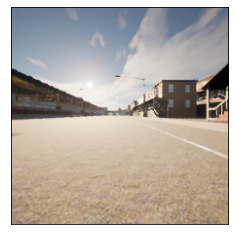

In [17]:
# Let's have a look at what our car sees
plt.imshow(train_imgs2[0].reshape(224, 224, 3)/255.)
plt.xticks(())
plt.yticks(());

In [18]:
# Clean up actors in test_car and clear object from memory
for actor in test_car.actor_list:
    actor.destroy()
del(test_car)

In [19]:
# We can now pass this image through the VGG19 CNN and observe what the output looks like
# Let's first get an idea of what the model input looks like
base_model = VGG19(weights='imagenet',
                   include_top=False,
                   input_shape=(224,
                                224,
                                3
                               )
                   )
base_model.input_shape

(None, 224, 224, 3)

In [20]:
# Testing to determine output shape of VGG19
prediction = base_model.predict(train_images[0].reshape(1, 224, 224, 3) / 255.)
prediction.shape

(1, 7, 7, 512)

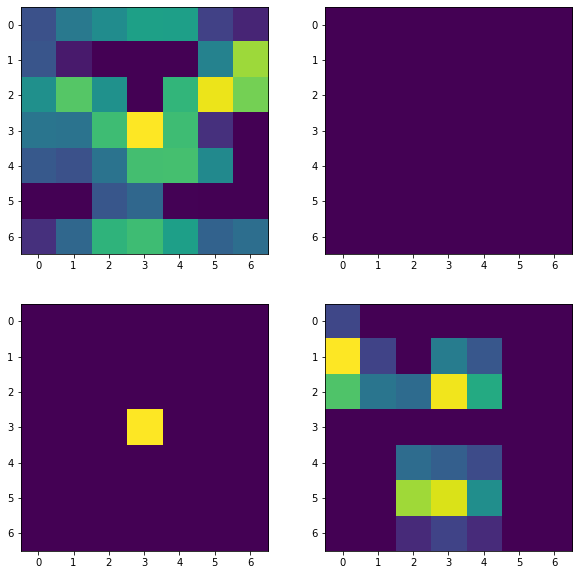

In [21]:
# We can see that the CNN has produced 512 7x7 convolutions. Let's look at some
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for i in range(4):
    col = i % 2
    row = i // 2
    axes[row, col].imshow(prediction[0][:, :, i])

While not very meaningful to us humans, these 7x7 images represent image features like edges to the computer, and may help to generalize the input we give to the ARS perceptron by relaying its content, rather than just the RGB input which can vary a lot in lighting and color for similar driving situations.

In [22]:
# We will need to flatten this output to make use of the ARS perceptron, let's see what this looks like.
prediction.flatten().shape

(25088,)

For ARS, inputs to the perceptron must be normalized. Usually, this is done by taking rolling statistics of the inputs, and using them to perform mean/std filtering to normalize future inputs. This allows the algorithm to build these distributions from scratch without needing prior information about them. For this context, the outputs of the CNN are going to be on the same scale, and just as RGB camera data can be normalized by dividing the pixel values by 255, we can similarly normalize the outputs of this CNN by finding out what scale they are on. We can do this by creating a histogram of the values within the output.

Maximum output value: 9.99218
Minimum output value: 0.0


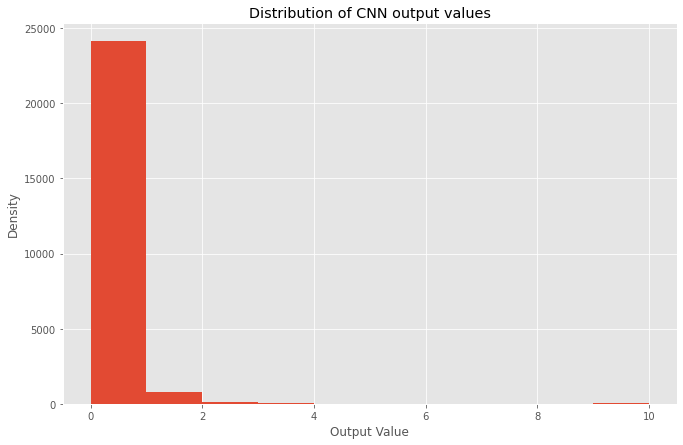

In [23]:
print('Maximum output value:', np.max(prediction))
print('Minimum output value:', np.min(prediction))

plt.style.use('ggplot')
plt.figure(figsize=(11,7))
plt.title('Distribution of CNN output values')
plt.xlabel('Output Value')
plt.ylabel('Density')
plt.hist(prediction.flatten());

We can see that these values are occurring on a scale between 0 and 10. This makes normalization easy, since all we need to do is divide all of these values by 10, just as we would divide RGB camera data by 255.

In [24]:
# Skow's ARSAgent class, heavily modified to make use of the CarEnv
# initial_train option is experimental, uses train_imgs to train
# some initial weights for the ARS process to start with.
class ARSAgent():
    def __init__(self,
                 hp=None,
                 env=None,
                 base_model=True,
                 policy=None,
                 weights_dir='ars_weights',
                 initial_train=False
                ):

        self.hp = hp or HP()
        np.random.seed(self.hp.seed)
        self.env = env or CarEnv(control_type='continuous')
        self.output_size = self.env.action_space.shape[0]
        self.record_video = False
        self.history = {'step': [],
                        'score': [],
                        'theta': []}
        self.generate_theta = False
        self.historical_steps = 0
        
        if base_model is None:
            self.input_size = self.env.front_camera.shape
        else:
            base_model = VGG19(weights='imagenet', 
                               include_top=False, 
                               input_shape=(self.env.img_height, self.env.img_width,3))
            input_size = 1
            for dim in base_model.output_shape:
                if dim is not None:
                    input_size *= dim
            self.input_size = input_size
            
        if policy is None and initial_train == True:
            self.generate_theta = True
        self.base_model = base_model
        self.policy = policy or Policy(self.input_size, self.output_size, self.hp)
        self.weights_dir = mkdir('', weights_dir)

    # Explore the policy on one specific direction and over one episode
    def explore(self, direction=None, delta=None):
        state = self.env.reset()
        done = False
        sum_rewards = 0.0
        steps = 0
        while not done:
            # Get data from front camera and divide by 255 to normalize
            state = self.env.front_camera.reshape(1, 224, 224, 3) / 255.
            steps += 1
            if self.base_model:
                # Use base model to make prediction, flatten and divide by 10 to normalize
                state = self.base_model.predict(state).flatten() / 10.
            else:
                state = state.flatten()
            action = self.policy.evaluate(state, delta, direction)
            state, reward, done, _ = self.env.step(action, steps)
            #reward = max(min(reward, 1), -1)
            sum_rewards += reward
        print('Worker saw {} steps'.format(steps))
        # Average the rewards per step to account for variable FPS seen by workers
        print('Sum of episode rewards:', sum_rewards)
        adjusted_reward = sum_rewards / steps
        print('Adjusted Reward for episode:', adjusted_reward)
        return adjusted_reward

    def train(self):
        # Experimental. Used to train an initial set of weights for ARS to modify.
        if self.generate_theta:
            print('Training initial weights...')
            pred_model = keras.models.Sequential()
            base_model = VGG19(weights='imagenet', 
                               include_top=False, 
                               input_shape=(224, 224,3))
            for layer in base_model.layers:
                layer.trainable = False
            pred_model.add(base_model)
            pred_model.add(keras.layers.Flatten())
            pred_model.add(Dense(3, input_dim=base_model.output_shape, activation='linear'))
            pred_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
            X = train_imgs.reshape(50, 224, 224, 3)/255.
            y = np.array([1., 0., 0.])
            y = np.tile(y, (50, 1))
            pred_model.fit(X, y, epochs=5, workers=2)
            self.policy.theta = pred_model.get_weights()[-2].T
        
        for step in range(self.hp.nb_steps):
            self.historical_steps += 1
            print('Performing step {}. ({}/{})'.format(self.historical_steps,
                                                       step + 1,
                                                       self.hp.nb_steps
                                                      ))
            start = time.time()
            # Only record video during evaluation, every n steps
            if step % self.hp.record_every == 0:
                self.env.show_cam = True
            # initialize the random noise deltas and the positive/negative rewards
            deltas = self.policy.sample_deltas()
            positive_rewards = [0] * self.hp.num_deltas
            negative_rewards = [0] * self.hp.num_deltas

            # play an episode each with positive deltas and negative deltas, collect rewards
            for k in range(self.hp.num_deltas):
                positive_rewards[k] = self.explore(direction="+", delta=deltas[k])
                negative_rewards[k] = self.explore(direction="-", delta=deltas[k])
                
            # Compute the standard deviation of all rewards
            sigma_rewards = np.array(positive_rewards + negative_rewards).std()

            # Sort the rollouts by the max(r_pos, r_neg) and select the deltas with best rewards
            scores = {k:max(r_pos, r_neg) for k,(r_pos,r_neg) in enumerate(zip(positive_rewards, negative_rewards))}
            order = sorted(scores.keys(), key = lambda x:scores[x], reverse = True)[:self.hp.num_best_deltas]
            rollouts = [(positive_rewards[k], negative_rewards[k], deltas[k]) for k in order]

            # Update the policy
            self.policy.update(rollouts, sigma_rewards)

            if step % self.hp.record_every == 0:
                # Play an episode with the new weights and print the score
                reward_evaluation = self.run_episode()
                print('Step:', step + 1, 'Reward:', reward_evaluation)
                self.history['step'].append(self.historical_steps)
                self.history['score'].append(reward_evaluation)
                self.history['theta'].append(self.policy.theta.copy())
                #self.save()
                
            end = time.time()
            print('Time to complete update step:', end - start)
            self.env.show_cam = False
        
        self.save()

    def save(self):
        save_file = mkdir(self.weights_dir, str(datetime.date.today()))
        np.savetxt(save_file+'/recent_weights.csv'.format(self.historical_steps), 
                   self.policy.theta,
                   delimiter=','
                  )  
            
    def run_episode(self):
        return self.explore()
            
    def clean_up(self):
        for actor in self.env.actor_list:
            actor.destroy()

In [25]:
# Establish hyperparameters to pass to agent
hp_test = HP(nb_steps=10, 
             noise=0.05, 
             learning_rate=0.02, 
             num_deltas=16, 
             num_best_deltas=8,
             record_every=1
            )

In [26]:
# Instantiate the agent using these hyperparameters
ars_agent = ARSAgent(hp=hp_test)

In [27]:
# Load in previously trained weights if you have some
#weights = np.genfromtxt('ars_weights/2020-12-21/recent_weights.csv', delimiter=',')
#ars_agent.policy.theta = weights

In [28]:
# Train the agent
ars_agent.train()

Performing step 1. (1/10)


Collision!
Worker saw 87 steps
Sum of episode rewards: 178.19068223474733
Adjusted Reward for episode: 2.048168761318935
Worker saw 113 steps
Sum of episode rewards: -1783.318041079285
Adjusted Reward for episode: -15.781575584772433
Worker saw 116 steps
Sum of episode rewards: -1334.701122012245
Adjusted Reward for episode: -11.506044155277973
Collision!
Worker saw 59 steps
Sum of episode rewards: 918.9166323928043
Adjusted Reward for episode: 15.574858176149226
Worker saw 112 steps
Sum of episode rewards: -1259.92121064013
Adjusted Reward for episode: -11.24929652357259
Worker saw 114 steps
Sum of episode rewards: -1579.342465086471
Adjusted Reward for episode: -13.853881272688342


We can see from the worker's reports of how many frames they saw that the FPS experienced by a worker is variable, which is why we computed the average reward per frame rather than the sum of rewards for each episode. We can also see that the amount of time it takes to complete each update step is rather large,at ~10.5 minutes. This would make a 1000 iteration training session take 175 hours, which is not feasible, and this is only with 16 deltas. This means we will need to have training done in parallel.

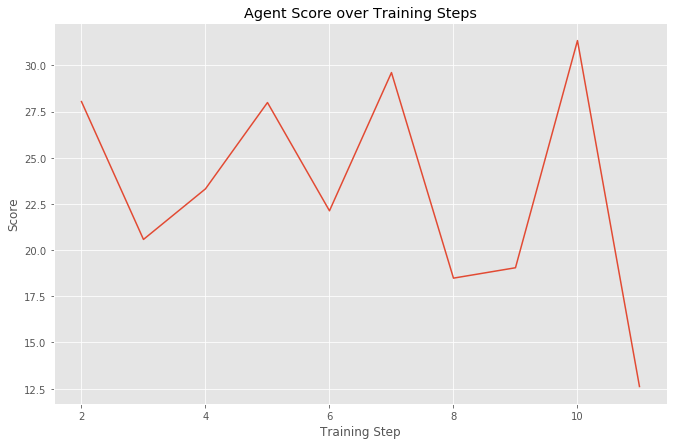

In [26]:
# Plotting the results of our brief training session.
plt.figure(figsize=(11, 7))
plt.plot(ars_agent.history['step'], ars_agent.history['score'])
plt.title('Agent Score over Training Steps')
plt.xlabel('Training Step')
plt.ylabel('Score');

In [27]:
# A quick sanity check to make sure that our theta was changing each time
for i, theta in enumerate(ars_agent.history['theta']):
    if i + 1 == len(ars_agent.history['theta']):
        break
    if np.array_equal(theta, ars_agent.history['theta'][i+1]):
        print('same')
    else:
        print('different')

different
different
different
different
different
different
different
different
different


In [28]:
# Save weights for later use
ars_agent.save()

In [14]:
# Clean up actors and clear agent from memory
ars_agent.clean_up()
del(ars_agent)

We can see that we have a functioning ARS Agent using our CarEnv environment, but training with a single car like this would take forever. We need to look into training cars in parallel. Fortunately, the authors of the 2018 paper have provided source code to run ARS training in parallel using Ray.io. As was necessary with the Skow code, this code needed to be heavily modified in order to work with the CarEnv. I have made extensive adjustments to their code for this study. My version of the code can be found in the ARS_Carla folder.

### Continue to next notebook
Click [here](notebook2_train_agent.ipynb) to proceed to the next notebook, where we train our agent using workers operating in parallel with the help of the Ray module.

## Appendix
This section contains dead code no longer used in this notebook, but stored down here for reference if needed. An attempt was made at using ipyparallel, which was not successful because it was unable to pickle the context objects, but luckily the Ray solution worked better.

In [3]:
# Skow's class to normalize inputs with rolling statistics
# Not used with the CarEnv since the outputs of the VGG19
# were all on the same scale, but it might be worth comparing
# using it later on.
class Normalizer():
    # Normalizes the inputs
    def __init__(self, nb_inputs):
        self.n = np.zeros(nb_inputs)
        self.mean = np.zeros(nb_inputs)
        self.mean_diff = np.zeros(nb_inputs)
        self.var = np.zeros(nb_inputs)

    def observe(self, x):
        self.n += 1.0
        last_mean = self.mean.copy()
        self.mean += (x - self.mean) / self.n
        self.mean_diff += (x - last_mean) * (x - self.mean)
        self.var = (self.mean_diff / self.n).clip(min = 1e-2)

    def normalize(self, inputs):
        obs_mean = self.mean
        obs_std = np.sqrt(self.var)
        return (inputs - obs_mean) / obs_std

In [4]:
# Original unmodified Skow Trainer class for reference
class ARSTrainer():
    def __init__(self,
                 hp=None,
                 input_size=None,
                 output_size=None,
                 normalizer=None,
                 policy=None,
                 monitor_dir=None):

        self.hp = hp or HP()
        np.random.seed(self.hp.seed)
        self.env = gym.make(self.hp.env_name)
        if monitor_dir is not None:
            should_record = lambda i: self.record_video
            self.env = wrappers.Monitor(self.env, monitor_dir, video_callable=should_record, force=True)
        self.hp.episode_length = self.hp.episode_length
        self.input_size = input_size or self.env.observation_space.shape[0]
        self.output_size = output_size or self.env.action_space.shape[0]
        self.normalizer = normalizer or Normalizer(self.input_size)
        self.policy = policy or Policy(self.input_size, self.output_size, self.hp)
        self.record_video = False

    # Explore the policy on one specific direction and over one episode
    def explore(self, direction=None, delta=None):
        state = self.env.reset()
        done = False
        num_plays = 0.0
        sum_rewards = 0.0
        while not done and num_plays < self.hp.episode_length:
            self.normalizer.observe(state)
            state = self.normalizer.normalize(state)
            action = self.policy.evaluate(state, delta, direction)
            state, reward, done, _ = self.env.step(action)
            reward = max(min(reward, 1), -1)
            sum_rewards += reward
            num_plays += 1
        return sum_rewards

    def train(self):
        for step in range(self.hp.nb_steps):
            # initialize the random noise deltas and the positive/negative rewards
            deltas = self.policy.sample_deltas()
            positive_rewards = [0] * self.hp.num_deltas
            negative_rewards = [0] * self.hp.num_deltas

            # play an episode each with positive deltas and negative deltas, collect rewards
            for k in range(self.hp.num_deltas):
                positive_rewards[k] = self.explore(direction="+", delta=deltas[k])
                negative_rewards[k] = self.explore(direction="-", delta=deltas[k])
                
            # Compute the standard deviation of all rewards
            sigma_rewards = np.array(positive_rewards + negative_rewards).std()

            # Sort the rollouts by the max(r_pos, r_neg) and select the deltas with best rewards
            scores = {k:max(r_pos, r_neg) for k,(r_pos,r_neg) in enumerate(zip(positive_rewards, negative_rewards))}
            order = sorted(scores.keys(), key = lambda x:scores[x], reverse = True)[:self.hp.num_best_deltas]
            rollouts = [(positive_rewards[k], negative_rewards[k], deltas[k]) for k in order]

            # Update the policy
            self.policy.update(rollouts, sigma_rewards)

            # Only record video during evaluation, every n steps
            if step % self.hp.record_every == 0:
                self.record_video = True
            # Play an episode with the new weights and print the score
            reward_evaluation = self.explore()
            print('Step: ', step, 'Reward: ', reward_evaluation)
            self.record_video = False

In [23]:
# This is an attempt to get the trainer to work with ipyparallel
# It did not work because ipyparallel will not pickle context objects
import ipyparallel as ipp
c = ipp.Client()
c[:].use_cloudpickle()

class ARSAgent_Parallel():
    def __init__(self,
                 hp=None,
                 num_envs=4,
                 base_model=True,
                 policy=None,
                 weights_dir='ars_weights',
                 initial_train=False
                ):

        self.hp = hp or HP()
        np.random.seed(self.hp.seed)
        self.envs = [CarEnv(control_type='continuous') for i in range(num_envs)]
        self.env = self.envs[0]
        self.output_size = self.env.action_space.shape[0]
        self.record_video = False
        self.history = {'step': [],
                        'score': [],
                        'theta': []}
        self.generate_theta = False
        self.historical_steps = 0
        
        if base_model is None:
            self.input_size = self.env.front_camera.shape
        else:
            base_model = VGG19(weights='imagenet', 
                               include_top=False, 
                               input_shape=(self.env.img_height, self.env.img_width,3))
            input_size = 1
            for dim in base_model.output_shape:
                if dim is not None:
                    input_size *= dim
            self.input_size = input_size
            
        if policy is None and initial_train == True:
            self.generate_theta = True
        self.base_model = base_model
        self.policy = policy or Policy(self.input_size, self.output_size, self.hp)
        self.weights_dir = mkdir('', weights_dir)
        
    # Explore the policy on one specific direction and over one episode
    def explore(self, direction=None, delta=None):
        state = self.env.reset()
        done = False
        sum_rewards = 0.0
        while not done:
            state = self.env.front_camera.reshape(1, 224, 224, 3)/255.
            if self.base_model:
                state = self.base_model.predict(state).flatten()
            else:
                state = state.flatten()
            action = self.policy.evaluate(state, delta, direction)
            state, reward, done, _ = self.env.step(action)
            reward = max(min(reward, 1), -1)
            sum_rewards += reward
        return sum_rewards

    # Explore the policy on one specific direction and over one episode
    def explore_directions(self, env):
        delta = np.random.randn(*self.policy.theta.shape)
        sum_positive_rewards = 0.0
        sum_negative_rewards = 0.0
        
        # Get positive direction for delta
        state = env.reset()
        done = False
        while not done:
            state = self.env.front_camera.reshape(1, 224, 224, 3)/255.
            if self.base_model:
                state = self.base_model.predict(state).flatten()
            else:
                state = state.flatten()
            action = self.policy.evaluate(state, delta, '+')
            state, reward, done, _ = self.env.step(action)
            #reward = max(min(reward, 1), -1)
            sum_positive_rewards += reward
            
        # Get negative direction for delta
        state = env.reset()
        done = False
        while not done:
            state = self.env.front_camera.reshape(1, 224, 224, 3)/255.
            if self.base_model:
                state = self.base_model.predict(state).flatten()
            else:
                state = state.flatten()
            action = self.policy.evaluate(state, delta, '-')
            state, reward, done, _ = self.env.step(action)
            reward = max(min(reward, 1), -1)
            sum_negative_rewards += reward
            
        return delta, sum_positive_rewards, sum_negative_rewards

    def train(self):
        if self.generate_theta:
            print('Training initial weights...')
            pred_model = keras.models.Sequential()
            base_model = VGG19(weights='imagenet', 
                               include_top=False, 
                               input_shape=(224, 224,3))
            for layer in base_model.layers:
                layer.trainable = False
            pred_model.add(base_model)
            pred_model.add(keras.layers.Flatten())
            pred_model.add(Dense(3, input_dim=base_model.output_shape, activation='linear'))
            pred_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
            X = train_imgs.reshape(50, 224, 224, 3)/255.
            y = np.array([1., 0., 0.])
            y = np.tile(y, (50, 1))
            pred_model.fit(X, y, epochs=5, workers=2)
            self.policy.theta = pred_model.get_weights()[-2].T
        
        for step in range(self.hp.nb_steps):
            print('Performing step {}. ({}/{})'.format(self.historical_steps,
                                                       step + 1,
                                                       self.hp.nb_steps
                                                      ))
            self.historical_steps += 1
            # Only record video during evaluation, every n steps
            if step % self.hp.record_every == 0:
                for env in self.envs:
                    env.show_cam = True
            # initialize the random noise deltas and the positive/negative rewards
            deltas = [] #self.policy.sample_deltas()
            positive_rewards = [] #[0] * self.hp.num_deltas
            negative_rewards = [] #[0] * self.hp.num_deltas

            # play an episode each with positive deltas and negative deltas, collect rewards
            for i in range(self.hp.num_deltas // 4):
                responses = c[:].map_sync(self.explore_directions, self.envs)
                for res in positive_responses:
                    deltas.append(res[0])
                    positive_rewards.append(res[1])
                    negative_rewards.append(res[3])
                
            # Compute the standard deviation of all rewards
            sigma_rewards = np.array(positive_rewards + negative_rewards).std()

            # Sort the rollouts by the max(r_pos, r_neg) and select the deltas with best rewards
            scores = {k:max(r_pos, r_neg) for k,(r_pos,r_neg) in enumerate(zip(positive_rewards, negative_rewards))}
            order = sorted(scores.keys(), key = lambda x:scores[x], reverse = True)[:self.hp.num_best_deltas]
            rollouts = [(positive_rewards[k], negative_rewards[k], deltas[k]) for k in order]

            # Update the policy
            self.policy.update(rollouts, sigma_rewards)

            if step % self.hp.record_every == 0:
                # Play an episode with the new weights and print the score
                reward_evaluation = self.run_episode()
                print('Step:', step + 1, 'Reward:', reward_evaluation)
                self.history['step'].append(self.historical_steps)
                self.history['score'].append(reward_evaluation)
                self.history['theta'].append(self.policy.theta.copy())
                
            self.env.show_cam = False
        
        save_file = mkdir(self.weights_dir, str(datetime.date.today()))
        np.savetxt(save_file+'/{}_episodes.csv'.format(self.historical_steps), 
                   self.policy.theta,
                   delimiter=','
                  )            
            
    def run_episode(self):
        return self.explore()
            
    def clean_up(self):
        for actor in self.env.actor_list:
            actor.destroy()

<AsyncResult: use_cloudpickle>

In [36]:
hp_test = HP(nb_steps=50, 
             noise=0.05, 
             learning_rate=0.02, 
             num_deltas=32, 
             num_best_deltas=16,
             record_every=1
            )

In [37]:
len(ars_agent.history['theta'])

26

In [38]:
ars_agent_parallel = ARSAgent_Parallel(hp=hp_test)

In [39]:
weights = ars_agent.history['theta'][-1]

In [40]:
ars_agent_parallel.policy.theta = weights

In [ ]:
ars_agent_parallel.train()

In [42]:
ars_agent_parallel.clean_up()

I'd like to try training in a variety of circumstances and with various combinations of inputs. The semantic segmentation cam may give great performance with camera-based training. There are also radar, lidar, and other sensors that can be added into the inputs. First, let's just set up a basic RGB cam and try to see what that can do. I am thinking that putting the VGG19 with imagenet weights in front of the ARS agent may help it find edges, so we need to compare both of these methods over a given number of episodes. Sentdex's scoring system is not badly designed, and it may be enlightening to know how my scores compare.